In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["font.family"] = "serif"
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
#from mpl_toolkits.basemap import Basemap
#from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid.inset_locator import inset_axes

import numpy as np
import sys, os
from netCDF4 import Dataset#, MFDataset
from datetime import datetime
import scipy.signal as sig
from scipy.ndimage import gaussian_filter
import scipy.interpolate as itp
from PIL import Image, ImageDraw
import json
import pandas as pd

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = KRYPTON+"local_ruchba/"

In [23]:
simul = "luckym2"
if simul in ['luckyt']:
    season = "_win"
    suff = season
else:
    season = ""
    suff = "-b" ""#

grid_file = KRYPTON+"/lucky_corgrd.nc"
doms_file = "../NRJ_flux_diag/subdomains_lucky.json"
dirpic = 'pictures/modal_conv_scatter/' #paper/'
dosavefig = False

filscat = KRYPTON+'{0}_modemap/{0}_mode_scatdiag{1}.nc'.format(simul,suff)
filcsv = "./{0}_diagscat{1}.csv".format(simul,suff)
data_Fa14 = KRYPTON+"Tide_Conv/Falahat_etal_2014_ModalConvM2.nc"

with open(doms_file, "r") as fp:
    mydoms = json.load(fp)
      
# unfold subdomains
doms, nams = [], []
for key,val in mydoms.items():
    if key == "ridges":
        for ido,dom in enumerate(val):
            doms.append(dom)
            nams.append(key.rstrip("s")+str(ido+1))
    else:
        doms.append(val)
        nams.append(key)

# load dataframe

#datfra = pd.read_csv(filcsv, header=[0,1], index_col=0)#, converters={'Cmn': eval})
datfra = pd.read_pickle(filcsv.replace("csv","pkl"))
nmod = len(datfra)

rho0 = 1025

/home/lahaye/Coding/virtual_envs/py3_libra_lab/lib/python3.5/site-packages/pandas/core/indexes/base.py:162: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)
/home/lahaye/Coding/virtual_envs/py3_libra_lab/lib/python3.5/site-packages/pandas/core/indexes/base.py:162: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


In [24]:
def eformat(f, prec=0, exp_digits=1):
    """Tweak number of digits in exponent -- could use numpy.format_float_scientific, but it's not available"""
    s = "%.*e"%(prec, f)
    mantissa, exp = s.split('e')
    # add 1 to digits as 1 is taken by sign +/-
    return "%se%+0*d"%(mantissa, exp_digits+1, int(exp))

def fformat(x):
    return "{:.2f}".format(x).replace("0.", ".")[:3+int(x<0)]

def set_myticks(vamp,vlin):
    """ warning vamp must have log10=0 """
    tab = np.arange(min(1,vamp),min(9,vamp)+1)
    for ii in range(int(round(np.log10(vamp/vlin)))-1):
        tab = np.r_[np.arange(1,10)/10**(ii+1), tab]
    return np.r_[-tab[::-1], 0, tab]

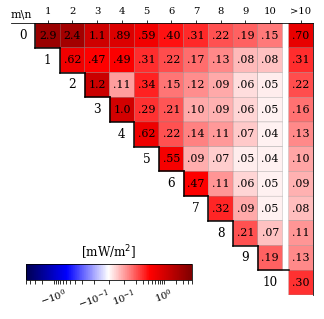

In [27]:
dom = "ridge2"
nmodplot = min(11, nmod)
vamp = 5
vlin = vamp/100
fs = 11
gcol = "grey"
glw = 1.5
cmap = "seismic"

indm = np.arange(nmodplot)
# load cmn matrix
cmn = np.zeros((nmod,nmod))
for imod in range(nmod):
    cmn[imod,imod+1:] = datfra["Cmn",dom][imod]*1e3 # mW/m^2
if nmodplot < nmod:
    toplot = np.c_[cmn[:nmodplot,:nmodplot], np.zeros((nmodplot,1)), cmn[:nmodplot,nmodplot:].sum(axis=1)]
    xmod = np.r_[np.arange(-.5, nmodplot, 1), nmodplot+np.array([-.25,+.75])]
else:
    toplot = cmn[:nmodplot,:nmodplot]
    xmod = np.arange(-.5, nmodplot, 1)

fig, axs = plt.subplots(1,1, figsize=(6,5))
ax = axs#[0]

ymod = np.arange(-.5, nmodplot, 1)
him = ax.pcolor(xmod, ymod, np.ma.masked_where(toplot==0,toplot), cmap=cmap, \
                norm=colors.SymLogNorm(linthresh=vlin, linscale=.1, vmin=-vamp, vmax=vamp), edgecolor="grey")
#him = ax.imshow(np.ma.masked_where(toplot==0,toplot), cmap=cmap, \
#                norm=colors.SymLogNorm(linthresh=vamp/10, vmin=-vamp, vmax=vamp))
cax = inset_axes(ax, width="55%", height="6%", loc="lower left", borderpad=1.5)
cbar = plt.colorbar(him, cax=cax, orientation='horizontal')#, extend="both", boundaries=[-vamp/5, vamp])
#ticks = np.linspace(-vamp,)
cax.set_title(r'[mW/m$^2$]')
#cbar.ax.set_xlim([-vamp/5, vamp])
mticks = set_myticks(vamp,vlin)
cbar.set_ticks(mticks)
labs = cbar.ax.get_xticklabels()
labs[len(mticks)//2].set_text("")
cbar.ax.set_xticklabels(labs, rotation=20)
ax.invert_yaxis()

# add values

for jj in indm:
    for ii in indm[jj+1:]:
        ax.text(ii, jj, fformat(toplot[jj,ii]), ha="center", va="center", fontsize=fs)
        #ax.text(ii, jj, "{:.2f}".format(cmn[jj,ii]), ha="center", va="center", fontsize=fs)
    ax.text(jj, jj, str(jj), ha="center", va="center", fontsize=fs+1)
if nmodplot < nmod:
    for jj in range(nmodplot):
        ax.text(nmodplot+.25, jj, fformat(toplot[jj,-1]), ha="center", va="center", fontsize=fs)

ax.set_xticks(np.r_[np.arange(1,nmodplot), nmodplot+.25])
ax.set_xticklabels([str(i) for i in range(1,nmodplot)]+[">10"])
ax.text(-.5,-.75,"m\\n",fontsize=fs)
#ax.set_yticks(np.arange(nmod))
ax.tick_params(top=True, bottom=False, left=False, labelleft=False,
                   labeltop=True, labelbottom=False)
for border in "left","bottom":
    ax.spines[border].set_visible(False)
ax.set_aspect(1)

for jj in range(nmodplot-2): # add special grid
    #ax.plot([jj+1.5,nmodplot-.5], [jj+.5,jj+.5], color=gcol, lw=glw)
    #ax.plot([jj+.5,jj+.5], [-.5,jj-.5], color=gcol, lw=glw-.5)
    ax.plot([jj+.5,jj+1.5], [jj+.5,jj+.5], color="k", lw=glw)
    ax.plot([jj+.5,jj+.5], [jj-.5,jj+.5], color="k", lw=glw)
jj += 1
ax.plot([jj+.5,jj+1.75], [jj+.5,jj+.5], color="k", lw=glw)
ax.plot([jj+.5,jj+.5], [jj-.5,jj+.5], color="k", lw=glw)
#jj += 1
#ax.plot([jj+.75,jj+1.75], [jj+.5,jj+.5], color="k", lw=glw)
#ax.plot([jj+.75,jj+.75], [jj-.5,jj+.5], color="k", lw=glw)

if dosavefig:
    fig.savefig(dirpic+"{0}_Cmn-mat_{1}.pdf".format(simul+season,dom), magnification="auto", bbox_inches="tight")

In [26]:
dosavefig

False

cbtrop 5303.846174379256
cbclin 1.4210854715202004e-13
ctot 5303.846174379258
divf 1261.3793548923318
diss 4042.466819486925


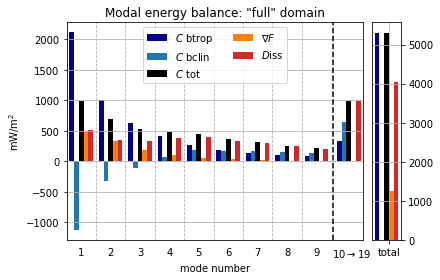

In [20]:
### copindexted from Calc_ModalNRJ_subdom.ipynb
# paper purpose: no linear theory but add sum 10 to 19 and put total with distinct y-axis

fields = ["cbtrop","cbclin","ctot","divf","diss"]
labs = [r"$C$ btrop", r"$C$ bclin",r"$C$ tot",r"$\nabla F$",r"$D$iss"]
cols = ["darkblue",'tab:blue',"black",'tab:orange','tab:red']

width = .8
nmod = 9
nmax= 19

prov = cmn - cmn.T
cbclin = prov[1:,1:].sum(axis=0)*1e3
cbtrop = cmn[0,1:]*1e3
ctot = cbclin+cbtrop
divf = datfra["divF",dom][1:].values *1e3*1025 # divfmoy[do][1:]*1e3
diss = ctot-divf

fig, axs = plt.subplots(1, 2, gridspec_kw={"width_ratios":[nmod+1,1]})
ax = axs[0]
for imod in range(nmod):
    for ifi,fie in enumerate(fields):
        lab = labs[ifi] if imod==0 else None
        ax.bar(imod+1-width/2+width*(ifi+.5)/len(fields), eval(fie)[imod], width/len(fields), 
               color=cols[ifi], label=lab)

ax.axvline(imod+1.55, color="k", linestyle="--")
imod += 1.1
for ifi,fie in enumerate(fields):
    lab = None
    ax.bar(imod+1-width/2+width*(ifi+.5)/len(fields), eval(fie)[nmod:nmax].sum(), width/len(fields), 
           color=cols[ifi], label=lab)
    print(fie,eval(fie).sum())

#ax.set_xticks(ind)
#ax.set_xticklabels(nams+['Total'], rotation=27, y=.03, ha="center")
ax.grid(True)
ax.set_xticks(np.r_[np.arange(1,nmod+1),nmod+1.2])
ax.set_xticklabels([str(ii) for ii in range(1,nmod+1)]+[str(nmod+1)+r"$\rightarrow$"+str(nmax)])
ax.grid(which="major", axis="x", linestyle="none")
ax.set_xticks(.5+np.arange(nmod), minor=True)
ax.grid(which="minor", axis="x", linestyle="--")
ax.tick_params(bottom=False, which="both")
ax.legend(ncol=2, loc="upper center")
ax.set_title('Modal energy balance: "{}" domain'.format(dom))
ax.set_xlabel("mode number")
ax.set_xlim([.5, nmod+1.6])  
ax.set_ylabel(r"mW/m$^2$")

ax = axs[1]
for ifi,fie in enumerate(fields):
    lab = None
    ax.bar(width*(ifi+.5)/len(fields), eval(fie).sum(), width/len(fields), 
           color=cols[ifi], label=lab)

ax.set_xticks([.5])
ax.set_xticklabels(['total'])
ax.yaxis.tick_right()
ax.set_xlim([-.1,.9])
ax.grid(True)

fig.subplots_adjust(wspace=.05)

if False:#dosavefig:
    fig.savefig("pictures/paper"+'ModalNRJbalance_{0}_n{1}o{2}.pdf'.format(do,str(nmod),str(nmax)), 
                    magnification='auto', bbox_inches="tight")